In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (
        Activation, BatchNormalization, Concatenate, Dense,
        Embedding, Flatten, Input, Multiply, Reshape, LeakyReLU, Conv2D, Conv2DTranspose)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

In [2]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

In [3]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100

num_classes = 10

In [4]:
def build_generator(z_dim):

    model = Sequential()

    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

#     model.add(BatchNormalization())

    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

#     model.add(BatchNormalization())

    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    model.add(Activation('tanh'))

    return model


def build_cgan_generator(z_dim):

    z = Input(shape=(z_dim, ))

    label = Input(shape=(1, ), dtype='int32')

    label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)

    label_embedding = Flatten()(label_embedding)

    joined_representation = Multiply()([z, label_embedding])

    generator = build_generator(z_dim)

    conditioned_img = generator(joined_representation)

    return Model([z, label], conditioned_img)

In [5]:
def build_discriminator(img_shape):

    model = Sequential()

    model.add(

        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=(img_shape[0], img_shape[1], img_shape[2] + 1),
               padding='same'))

    model.add(LeakyReLU(alpha=0.01))

    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

#     model.add(BatchNormalization())

    model.add(LeakyReLU(alpha=0.01))

    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

#     model.add(BatchNormalization())

    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model


def build_cgan_discriminator(img_shape):

    img = Input(shape=img_shape)

    label = Input(shape=(1, ), dtype='int32')

    label_embedding = Embedding(num_classes,
                                np.prod(img_shape),
                                input_length=1)(label)

    label_embedding = Flatten()(label_embedding)

    label_embedding = Reshape(img_shape)(label_embedding)

    concatenated = Concatenate(axis=-1)([img, label_embedding])

    discriminator = build_discriminator(img_shape)

    classification = discriminator(concatenated)

    return Model([img, label], classification)

In [6]:
def build_cgan(generator, discriminator):

    z = Input(shape=(z_dim, ))

    label = Input(shape=(1, ))

    img = generator([z, label])

    classification = discriminator([img, label])

    model = Model([z, label], classification)

    return model


discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(learning_rate=4e-4),
                      metrics=['accuracy'])

generator = build_cgan_generator(z_dim)

discriminator.trainable = False

cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4))

2021-10-19 22:44:55.563633: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 22:44:55.568032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 22:44:55.568272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 22:44:55.568644: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
accuracies = []
losses = []


def train(iterations, batch_size, sample_interval):

#     (X_train, y_train), (_, _) = mnist.load_data()
    (X_train, y_train), (x_test, y_test)  = mnist.load_data()
    X_train = np.concatenate([X_train, x_test])
    y_train = np.concatenate([y_train, y_test])

    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)
    real_noise = np.asarray([.9] * batch_size)
    real = np.ones((batch_size, 1))

    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):



        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]

        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict([z, labels])

        d_loss_real = discriminator.train_on_batch([imgs, labels], real)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        z = np.random.normal(0, 1, (batch_size, z_dim))

        labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

        g_loss = cgan.train_on_batch([z, labels], real)

        if (iteration + 1) % sample_interval == 0:

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss[0], 100 * d_loss[1], g_loss))

            losses.append((d_loss[0], g_loss))
            accuracies.append(100 * d_loss[1])

            sample_images()

In [8]:
def sample_images(image_grid_rows=2, image_grid_columns=5):

    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    labels = np.arange(0, 10).reshape(-1, 1)

    gen_imgs = generator.predict([z, labels])

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(10, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title("Digit: %d" % labels[cnt])
            cnt += 1

2021-10-19 22:44:56.539843: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-19 22:44:57.175529: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
2021-10-19 22:45:36.698650: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


1000 [D loss: 0.001761, acc.: 100.00%] [G loss: 9.180946]
2000 [D loss: 0.000727, acc.: 100.00%] [G loss: 8.808760]
3000 [D loss: 0.000022, acc.: 100.00%] [G loss: 10.151700]
4000 [D loss: 0.000326, acc.: 100.00%] [G loss: 7.650296]
5000 [D loss: 0.000014, acc.: 100.00%] [G loss: 10.822697]
6000 [D loss: 0.000008, acc.: 100.00%] [G loss: 11.614662]


2021-10-19 22:51:18.193717: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


7000 [D loss: 0.000033, acc.: 100.00%] [G loss: 9.732983]
8000 [D loss: 0.000008, acc.: 100.00%] [G loss: 11.659439]
9000 [D loss: 0.000002, acc.: 100.00%] [G loss: 12.405093]
10000 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.977039]
11000 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.741954]
12000 [D loss: 0.000000, acc.: 100.00%] [G loss: 15.637563]
13000 [D loss: 0.000000, acc.: 100.00%] [G loss: 17.050276]
14000 [D loss: 0.000000, acc.: 100.00%] [G loss: 17.659866]
15000 [D loss: 0.000000, acc.: 100.00%] [G loss: 18.189545]
16000 [D loss: 0.000000, acc.: 100.00%] [G loss: 18.698406]
17000 [D loss: 0.000002, acc.: 100.00%] [G loss: 13.113770]
18000 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.248724]
19000 [D loss: 0.000000, acc.: 100.00%] [G loss: 15.381351]
20000 [D loss: 0.000000, acc.: 100.00%] [G loss: 17.302679]


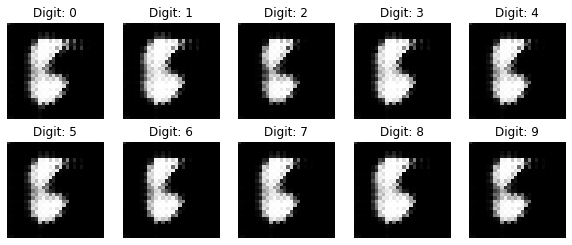

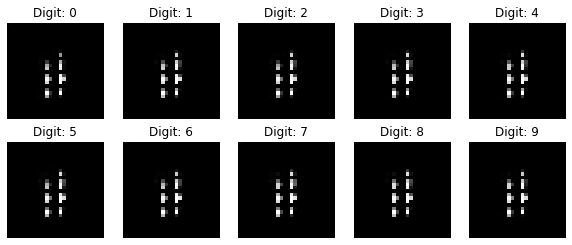

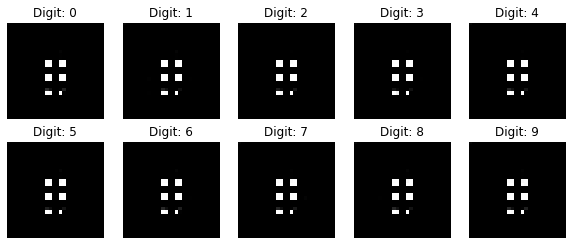

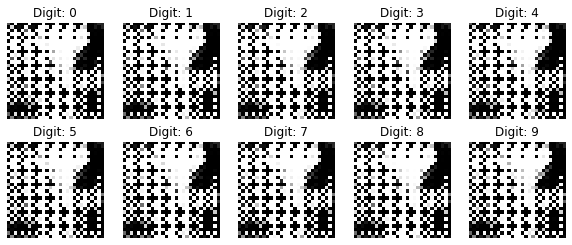

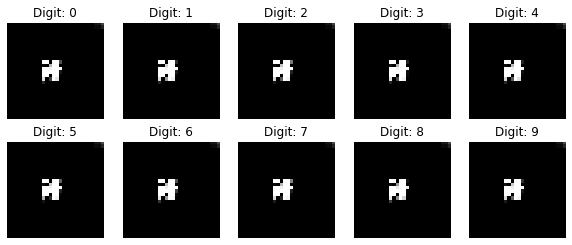

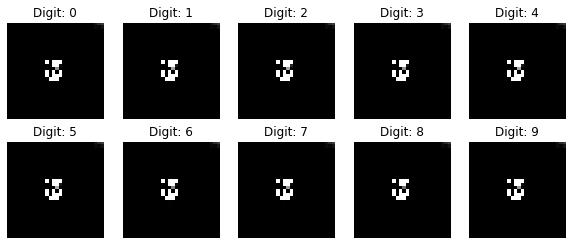

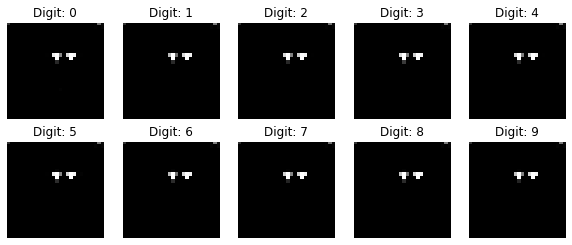

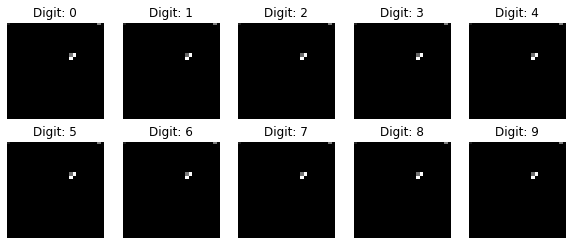

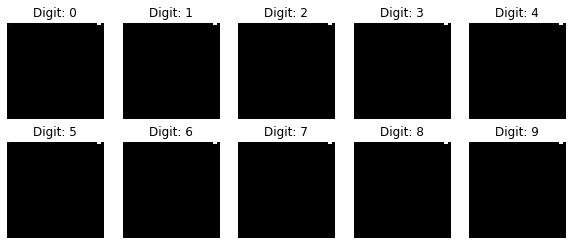

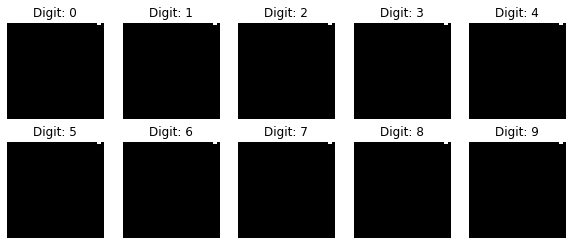

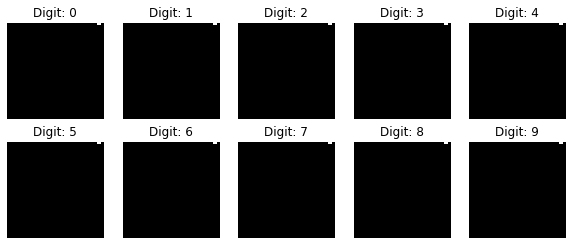

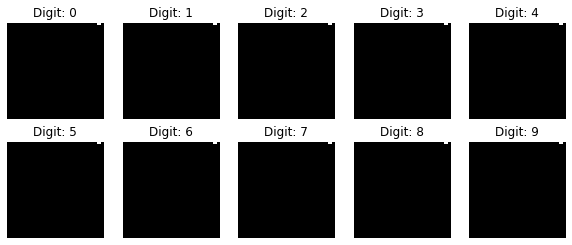

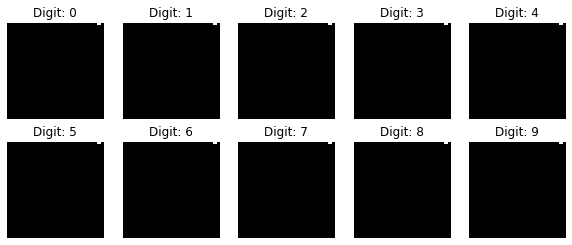

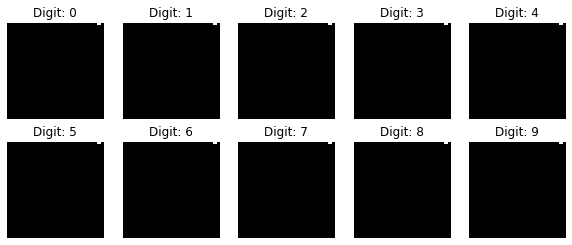

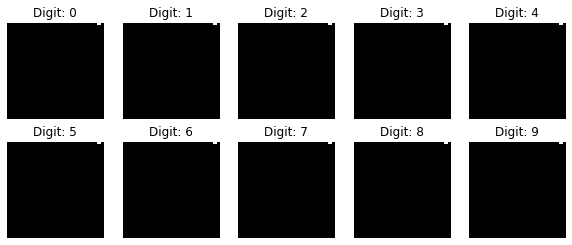

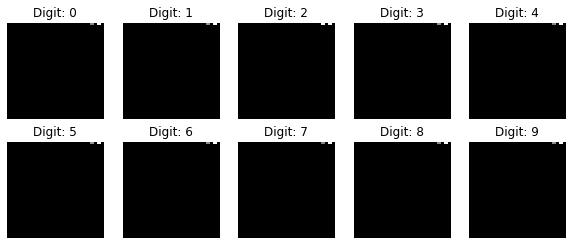

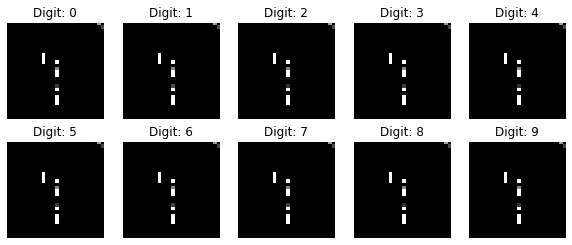

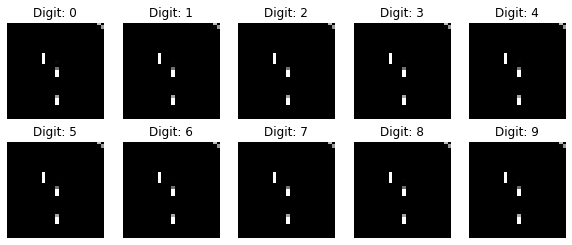

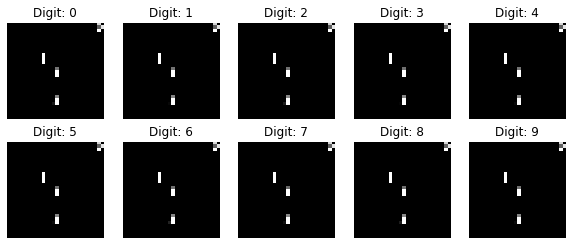

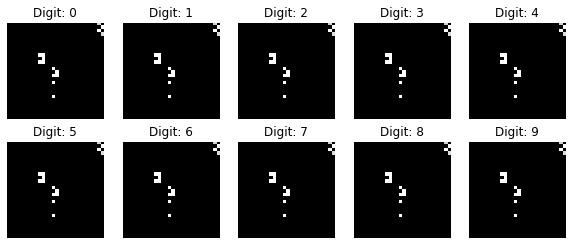

In [9]:
iterations = 20000
batch_size = 32
sample_interval = 1000

train(iterations, batch_size, sample_interval)

In [10]:
# iterations = 12000
# batch_size = 32
# sample_interval = 1000

# train(iterations, batch_size, sample_interval)